In [91]:
import pandas as pd 
import os, glob
import matplotlib.pyplot as plt 
import numpy as np

MINUTES = 15

df = pd.concat((pd.read_csv(f, engine="python", header=0) for f in glob.glob(r"gemini_BTCUSD_20[12][0]*.csv")))

df.head(10)


,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1613779320000,2021-02-20 00:02:00,BTCUSD,56178.00,56200.00,56141.15,56200.00,4.708759
1,1613779260000,2021-02-20 00:01:00,BTCUSD,56034.59,56178.00,56034.59,56178.00,2.000919
2,1613779200000,2021-02-20 00:00:00,BTCUSD,55984.59,56102.16,55984.59,56034.59,10.365388
3,1613779140000,2021-02-19 23:59:00,BTCUSD,55955.70,55984.59,55896.01,55984.59,0.416505
4,1613779080000,2021-02-19 23:58:00,BTCUSD,55999.97,55999.97,55899.67,55955.70,0.496324
5,1613779020000,2021-02-19 23:57:00,BTCUSD,55950.51,55999.97,55926.57,55999.97,3.811466
6,1613778960000,2021-02-19 23:56:00,BTCUSD,55893.14,55954.71,55867.55,55950.51,2.896990
7,1613778900000,2021-02-19 23:55:00,BTCUSD,55880.01,55923.53,55857.30,55893.14,0.756757
8,1613778840000,2021-02-19 23:54:00,BTCUSD,55862.03,55880.01,55837.52,55880.01,0.256260
9,1613778780000,2021-02-19 23:53:00,BTCUSD,55844.76,55923.23,55844.76,55862.03,0.084607


In [92]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d %H:%M:%S")
df = df.drop(["Symbol", "High", "Low"], axis=1)
df.dtypes

Unix Timestamp             int64
Date              datetime64[ns]
Open                     float64
Close                    float64
Volume                   float64
dtype: object

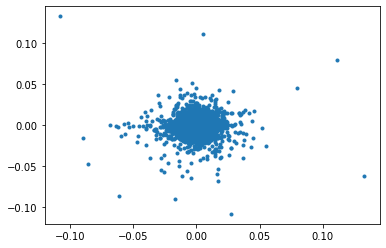

,Open,Close,Volume,diff,inc
Date,,,,,
2020-01-01 00:00:00,7165.90,7163.00,1.829030,-0.000405,0
2020-01-01 00:05:00,7163.00,7157.29,32.743381,-0.000798,0
2020-01-01 00:10:00,7157.29,7158.13,1.034611,0.000117,0
2020-01-01 00:15:00,7158.13,7151.67,13.002809,-0.000903,0
2020-01-01 00:20:00,7151.67,7151.67,22.904226,0.000000,0
2020-01-01 00:25:00,7151.67,7157.29,1.172976,0.000785,1
2020-01-01 00:30:00,7157.29,7157.40,9.463546,0.000015,0
2020-01-01 00:35:00,7157.40,7149.18,22.143328,-0.001150,0
2020-01-01 00:40:00,7149.18,7154.00,0.466071,0.000674,1


In [118]:
df_resample = df.resample("5T", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum})
df_resample["diff"] = (df_resample["Close"] - df_resample["Open"])/df_resample["Close"]
df_resample["inc"] = df_resample["diff"].apply(lambda x: 1 if x > 0.0005 else 0)
df_resample = df_resample.dropna()
df_resample.head(15)
plt.plot(df_resample["diff"], df_resample["diff"].shift(1), ".")
plt.show()
df_resample.head(15)

In [119]:
x = np.array([df_resample["inc"], df_resample["inc"].shift(1)])
unique, counts = np.unique(x.T, return_counts=True, axis=0)
rise_rise_idx = unique.tolist().index([1, 1])
fall_rise_idx = unique.tolist().index([0, 1])
fall_fall_idx = unique.tolist().index([0, 0])
rise_fall_idx = unique.tolist().index([1, 0])
print("Rises after rising: ", counts[rise_rise_idx]/(counts[rise_rise_idx]+counts[rise_fall_idx]))
print("Falls after falling: ", counts[fall_fall_idx]/(counts[fall_fall_idx]+counts[fall_rise_idx]))
print("Falls after rising: ", counts[rise_fall_idx]/(counts[rise_rise_idx]+counts[rise_fall_idx]))
print("Rises after falling: ", counts[fall_rise_idx]/(counts[fall_rise_idx]+counts[fall_fall_idx]))
unique, counts

Rises after rising:  0.33574044198612074
Falls after falling:  0.6568506832824014
Falls after rising:  0.6642595580138793
Rises after falling:  0.34314931671759863


(array([[ 0.,  0.],
        [ 0.,  1.],
        [ 0., nan],
        [ 1.,  0.],
        [ 1.,  1.]]),
 array([49652, 25939,     1, 25940, 13111]))

In [122]:
USD_start = 100
USD = USD_start
selloff = 0.0
buyup = 0.0
percent_buy = 1
do_selloff = False
BTC = 0

# active
prev_row = df_resample.iloc[0]
for index, row in df_resample.iterrows():
    if (index == 0): continue
    if (prev_row["inc"] == 0 and USD > 0):
        BTC += USD * percent_buy / row["Open"]
        USD = USD * (1 - percent_buy)
    elif (prev_row["inc"] == 1 and BTC > 0):
        USD += BTC * row["Close"]
        BTC = 0
    prev_row = row;

# buy and hold
print(df_resample.iloc[0]["Open"], df_resample.iloc[-1]["Close"], df_resample.iloc[-1]["Close"]/df_resample.iloc[0]["Open"])
USD += BTC * df_resample.iloc[-1]["Close"]
print(USD, USD_start*(df_resample.iloc[-1]["Close"]/df_resample.iloc[0]["Open"]))
print(USD/USD_start)

7165.9 56200.0 7.842699451569238
1501.7127550677767 784.2699451569238
15.017127550677767
